In [140]:
!git clone https://github.com/shobhitsundriyal/Track_Data_1.git

fatal: destination path 'Track_Data_1' already exists and is not an empty directory.


In [141]:
!ls Track_Data_1

driving_log.csv  IMG  readme.md


In [142]:
!pip install imgaug

In [0]:
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
import cv2
import pandas as pd
import ntpath
import matplotlib.image as mpimg
import random
from imgaug import augmenters as iaa

In [177]:
datadir = 'Track_Data_1'
coloums = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names=coloums)
pd.set_option('display.max_colwidth', -1)
data.head()

center  \
0  Z:\0self driving track data2\IMG\center_2018_09_23_01_24_50_436.jpg   
1  Z:\0self driving track data2\IMG\center_2018_09_23_01_24_50_536.jpg   
2  Z:\0self driving track data2\IMG\center_2018_09_23_01_24_50_638.jpg   
3  Z:\0self driving track data2\IMG\center_2018_09_23_01_24_50_739.jpg   
4  Z:\0self driving track data2\IMG\center_2018_09_23_01_24_50_840.jpg   

                                                                 left  \
0   Z:\0self driving track data2\IMG\left_2018_09_23_01_24_50_436.jpg   
1   Z:\0self driving track data2\IMG\left_2018_09_23_01_24_50_536.jpg   
2   Z:\0self driving track data2\IMG\left_2018_09_23_01_24_50_638.jpg   
3   Z:\0self driving track data2\IMG\left_2018_09_23_01_24_50_739.jpg   
4   Z:\0self driving track data2\IMG\left_2018_09_23_01_24_50_840.jpg   

                                                                 right  \
0   Z:\0self driving track data2\IMG\right_2018_09_23_01_24_50_436.jpg   
1   Z:\0self driving track data2\IMG\right_2018_09_23_01_24_50_536.jpg   
2   Z:\0self driving track data2\IMG\right_2018_09_23_01_24_50_638.jpg   
3   Z:\0self driving track data2\IMG\right_2018_09_23_01_24_50_739.jpg   
4   Z:\0self driving track data2\IMG\right_2018_09_23_01_24_50_840.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0        0.000083  
1  0.0       0.0       0        0.000078  
2  0.0       0.0       0        0.000081  
3  0.0       0.0       0        0.000079  
4  0.0       0.0       0        0.000079

In [178]:
def path_split(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_split)
data['right'] = data['right'].apply(path_split)
data['left'] = data['left'].apply(path_split)
  
data.head()

center                              left  \
0  center_2018_09_23_01_24_50_436.jpg  left_2018_09_23_01_24_50_436.jpg   
1  center_2018_09_23_01_24_50_536.jpg  left_2018_09_23_01_24_50_536.jpg   
2  center_2018_09_23_01_24_50_638.jpg  left_2018_09_23_01_24_50_638.jpg   
3  center_2018_09_23_01_24_50_739.jpg  left_2018_09_23_01_24_50_739.jpg   
4  center_2018_09_23_01_24_50_840.jpg  left_2018_09_23_01_24_50_840.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_09_23_01_24_50_436.jpg  0.0       0.0       0        0.000083  
1  right_2018_09_23_01_24_50_536.jpg  0.0       0.0       0        0.000078  
2  right_2018_09_23_01_24_50_638.jpg  0.0       0.0       0        0.000081  
3  right_2018_09_23_01_24_50_739.jpg  0.0       0.0       0        0.000079  
4  right_2018_09_23_01_24_50_840.jpg  0.0       0.0       0        0.000079

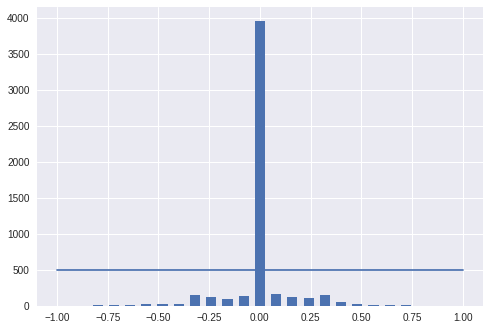

In [179]:
n_bins = 25
samples_per_bin = 500
hist, bins = np.histogram(data['steering'], n_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [180]:
print('total data:', len(data))
remove_list = []
for j in range(n_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (n_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 5230
removed: 3457
remaining: 1773


In [181]:
print(data.iloc[1])

center      center_2018_09_23_01_24_51_348.jpg
left        left_2018_09_23_01_24_51_348.jpg  
right       right_2018_09_23_01_24_51_348.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.80905e-05                       
Name: 9, dtype: object


In [0]:
def load_img(datadir, df):
  image_path = []
  steering =[]
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center , left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steering

image_paths, steering = load_img(datadir + '/IMG', data)

In [183]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering, test_size=0.2)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1418
Valid Samples: 355


In [184]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=n_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=n_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5,1,'Validation set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5,1,'Zoomed Image')

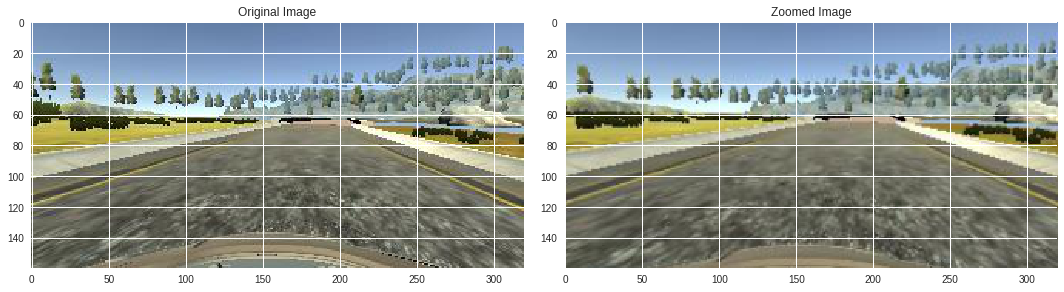

In [186]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image


Text(0.5,1,'Panned Image')

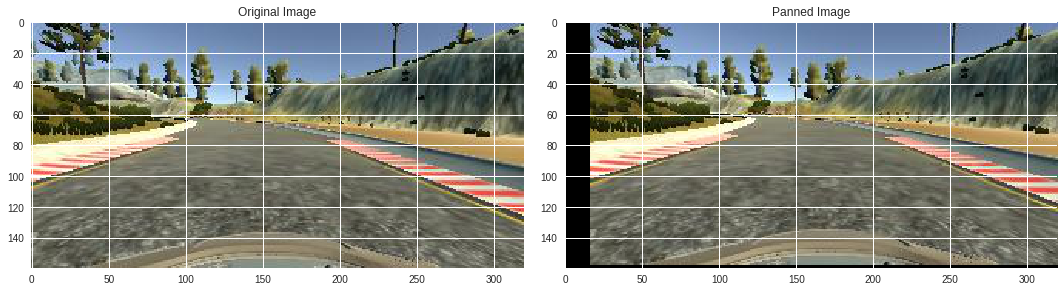

In [188]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

In [190]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')


Text(0.5,1,'Brightness altered image ')

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5,1,'Flipped Image - Steering Angle:-0.0')

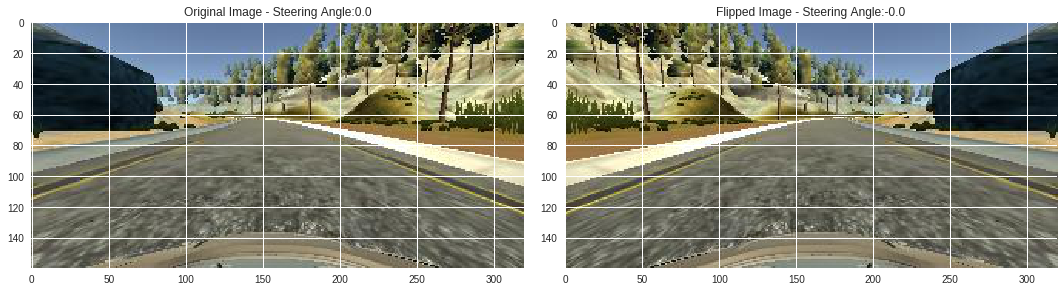

In [192]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steering[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

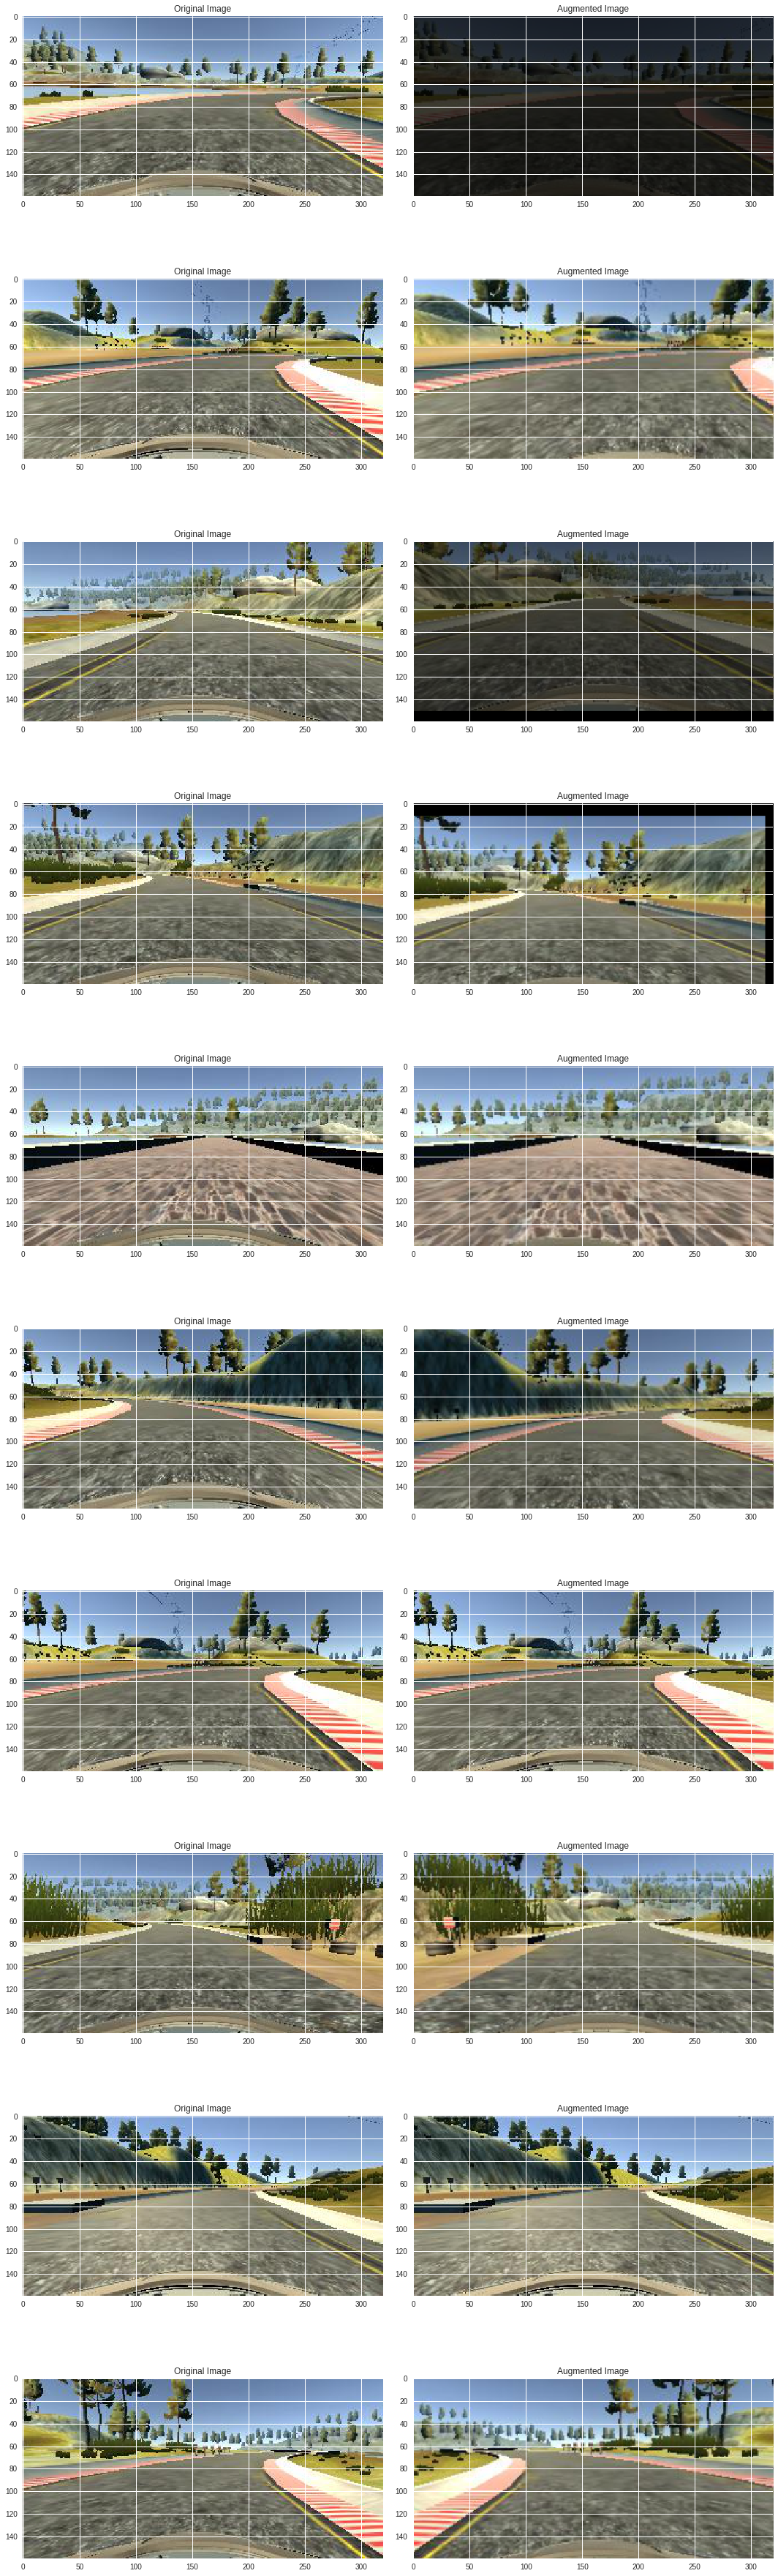

In [194]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steering[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, ssteering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [0]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5,1,'Validation Image')

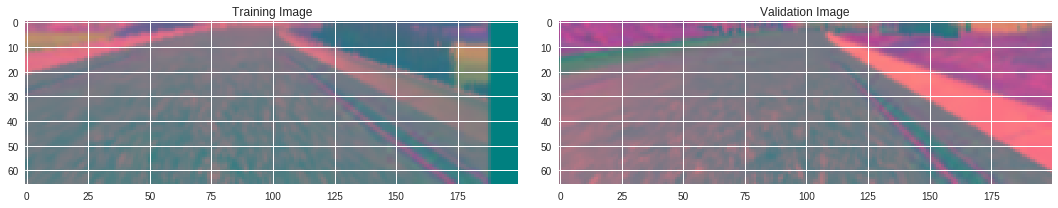

In [197]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

Text(0.5,1,'Preprocessed Image')

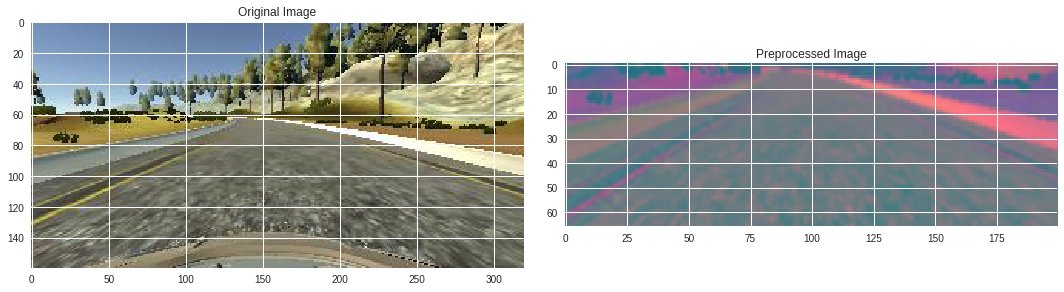

In [198]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


In [0]:
#X_train = np.array(list(map(img_preprocess, X_train)))
#X_valid = np.array(list(map(img_preprocess, X_valid)))

In [0]:
#plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
#plt.axis('off')
#print(X_train.shape)

In [0]:
def nvidia_model():#relu had very bad training now using elu
  model = Sequential()
  model.add(Convolution2D(24, 5,5, subsample=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, 5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48, 5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64, 3,3, activation='elu'))
  model.add(Convolution2D(64, 3,3, activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model


In [202]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               115300    
__________

In [203]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), steps_per_epoch=300, epochs=35,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0), 
                              validation_steps=200, 
                              verbose=1, 
                              shuffle=1)

Epoch 1/35
300/300 [==============================] - 173s 578ms/step - loss: 0.0884 - val_loss: 0.0526
Epoch 2/35
300/300 [==============================] - 168s 559ms/step - loss: 0.0660 - val_loss: 0.0476
Epoch 3/35
300/300 [==============================] - 167s 557ms/step - loss: 0.0610 - val_loss: 0.0450
Epoch 4/35
300/300 [==============================] - 167s 557ms/step - loss: 0.0591 - val_loss: 0.0436
Epoch 5/35
300/300 [==============================] - 168s 561ms/step - loss: 0.0583 - val_loss: 0.0426
Epoch 6/35
300/300 [==============================] - 168s 559ms/step - loss: 0.0561 - val_loss: 0.0411
Epoch 7/35
300/300 [==============================] - 169s 565ms/step - loss: 0.0568 - val_loss: 0.0424
Epoch 8/35
300/300 [==============================] - 170s 566ms/step - loss: 0.0545 - val_loss: 0.0418
Epoch 9/35
300/300 [==============================] - 168s 559ms/step - loss: 0.0551 - val_loss: 0.0429
Epoch 10/35
300/300 [==============================] - 168s 562m

Text(0.5,0,'Epoch')

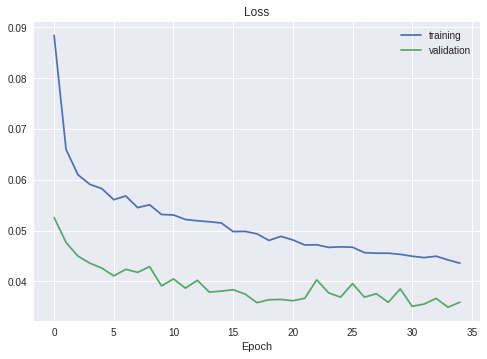

In [204]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model1.h5')

In [206]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [207]:
import shutil
src = 'model.h5'
dest = 'gdrive/My Drive/xbehaviour_cloning.h5'
shutil.copy(src, dest)

'gdrive/My Drive/xbehaviour_cloning.h5'